# Machine Learning Engineer Nanodegree
## Reinforcement Learning
## Project: Train a Smartcab to Drive

Welcome to the fourth project of the Machine Learning Engineer Nanodegree! In this notebook, template code has already been provided for you to aid in your analysis of the *Smartcab* and your implemented learning algorithm. You will not need to modify the included code beyond what is requested. There will be questions that you must answer which relate to the project and the visualizations provided in the notebook. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide in `agent.py`.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

-----

## Getting Started
In this project, you will work towards constructing an optimized Q-Learning driving agent that will navigate a *Smartcab* through its environment towards a goal. Since the *Smartcab* is expected to drive passengers from one location to another, the driving agent will be evaluated on two very important metrics: **Safety** and **Reliability**. A driving agent that gets the *Smartcab* to its destination while running red lights or narrowly avoiding accidents would be considered **unsafe**. Similarly, a driving agent that frequently fails to reach the destination in time would be considered **unreliable**. Maximizing the driving agent's **safety** and **reliability** would ensure that *Smartcabs* have a permanent place in the transportation industry.

**Safety** and **Reliability** are measured using a letter-grade system as follows:

| Grade 	| Safety 	| Reliability 	|
|:-----:	|:------:	|:-----------:	|
|   A+  	|  Agent commits no traffic violations,<br/>and always chooses the correct action. | Agent reaches the destination in time<br />for 100% of trips. |
|   A   	|  Agent commits few minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 90% of trips. |
|   B   	| Agent commits frequent minor traffic violations,<br/>such as failing to move on a green light. | Agent reaches the destination on time<br />for at least 80% of trips. |
|   C   	|  Agent commits at least one major traffic violation,<br/> such as driving through a red light. | Agent reaches the destination on time<br />for at least 70% of trips. |
|   D   	| Agent causes at least one minor accident,<br/> such as turning left on green with oncoming traffic.       	| Agent reaches the destination on time<br />for at least 60% of trips. |
|   F   	|  Agent causes at least one major accident,<br />such as driving through a red light with cross-traffic.      	| Agent fails to reach the destination on time<br />for at least 60% of trips. |

To assist evaluating these important metrics, you will need to load visualization code that will be used later on in the project. Run the code cell below to import this code which is required for your analysis.

In [2]:
# Import the visualization code
import visuals as vs

# Pretty display for notebooks
%matplotlib inline

### Understand the World
Before starting to work on implementing your driving agent, it's necessary to first understand the world (environment) which the *Smartcab* and driving agent work in. One of the major components to building a self-learning agent is understanding the characteristics about the agent, which includes how the agent operates. To begin, simply run the `agent.py` agent code exactly how it is -- no need to make any additions whatsoever. Let the resulting simulation run for some time to see the various working components. Note that in the visual simulation (if enabled), the **white vehicle** is the *Smartcab*.

### Question 1
In a few sentences, describe what you observe during the simulation when running the default `agent.py` agent code. Some things you could consider:
- *Does the Smartcab move at all during the simulation?*
- *What kind of rewards is the driving agent receiving?*
- *How does the light changing color affect the rewards?*  

**Hint:** From the `/smartcab/` top-level directory (where this notebook is located), run the command 
```bash
'python smartcab/agent.py'
```

**Answer:**

A Smartcab does not move during the simulation. But it still receives positive and negative rewards for not taking an action. Positive if idling at a red light and negative if idling at a green light. When light color changes the value of reward changes its sign and sets the reward to some basic value.

### Understand the Code
In addition to understanding the world, it is also necessary to understand the code itself that governs how the world, simulation, and so on operate. Attempting to create a driving agent would be difficult without having at least explored the *"hidden"* devices that make everything work. In the `/smartcab/` top-level directory, there are two folders: `/logs/` (which will be used later) and `/smartcab/`. Open the `/smartcab/` folder and explore each Python file included, then answer the following question.

### Question 2
- *In the *`agent.py`* Python file, choose three flags that can be set and explain how they change the simulation.*
- *In the *`environment.py`* Python file, what Environment class function is called when an agent performs an action?*
- *In the *`simulator.py`* Python file, what is the difference between the *`'render_text()'`* function and the *`'render()'`* function?*
- *In the *`planner.py`* Python file, will the *`'next_waypoint()`* function consider the North-South or East-West direction first?*

**Answer:**

**agent.py**

`Environment` class accepts three flags. One of them is `verbose`. This flag makes logs more detailed if set to `True`. E.g. position of smartcab, occurrences of violations, heading and some more can be logged using this flag. 

`Simulator` class accepts four flags e.g. `display`. Setting `display` to `False` disables GUI and logs become the only available output.

`set_primary_agent` method of `Environment` class accepts `enforce_deadline` flag that being set to `True` leads to termination of trial if deadline reached zero.

**environment.py**

When an agent performs an action then `act` function of `Environment` class is called.

**simulator.py**

Function `render_text` prints text as logs while `render` draws simulation.

**planner.py**

Function `next_waypoint` considers East-West direction first.

-----
## Implement a Basic Driving Agent

The first step to creating an optimized Q-Learning driving agent is getting the agent to actually take valid actions. In this case, a valid action is one of `None`, (do nothing) `'left'` (turn left), `right'` (turn right), or `'forward'` (go forward). For your first implementation, navigate to the `'choose_action()'` agent function and make the driving agent randomly choose one of these actions. Note that you have access to several class variables that will help you write this functionality, such as `'self.learning'` and `'self.valid_actions'`. Once implemented, run the agent file and simulation briefly to confirm that your driving agent is taking a random action each time step.

In [3]:
import pandas as pd
import numpy as np
import ast

def print_additional_metrics(data):   
    data['average_reward'] = (data['net_reward'] / (data['initial_deadline'] - data['final_deadline'])).rolling(window=10, center=False).mean()
    print "Average Reward {}".format(data['average_reward'].mean())

    # Create additional features
    data['good_actions'] = data['actions'].apply(lambda x: ast.literal_eval(x)[0])
    data['good'] = (data['good_actions'] * 1.0 / \
        (data['initial_deadline'] - data['final_deadline'])).rolling(window=10, center=False).mean()

    # Average fraction of bad actions
    bad_actions_mean = 1-data['good'].mean()
    bad_actions_median = 1-data['good'].median()
    print "Bad Actions Mean {}".format(bad_actions_mean)
    print "Bad Actions Median {}".format(bad_actions_median)

    data['minor_acc'] = (data['actions'].apply(lambda x: ast.literal_eval(x)[3]) * 1.0 / \
        (data['initial_deadline'] - data['final_deadline'])).rolling(window=10, center=False).mean()
    data['major_acc'] = (data['actions'].apply(lambda x: ast.literal_eval(x)[4]) * 1.0 / \
        (data['initial_deadline'] - data['final_deadline'])).rolling(window=10, center=False).mean()

    data['minor'] = (data['actions'].apply(lambda x: ast.literal_eval(x)[1]) * 1.0 / \
        (data['initial_deadline'] - data['final_deadline'])).rolling(window=10, center=False).mean()
    data['major'] = (data['actions'].apply(lambda x: ast.literal_eval(x)[2]) * 1.0 / \
        (data['initial_deadline'] - data['final_deadline'])).rolling(window=10, center=False).mean()
    
    print "Average probability of major accident {}".format(data['major_acc'].mean())

    # Average fraction of actions that lead to accidents
    print "Fraction of actions that led to accidents {}".format((data['minor_acc'].mean() + data['major_acc'].mean()) / bad_actions_mean)

### Basic Agent Simulation Results
To obtain results from the initial simulation, you will need to adjust following flags:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.

Optionally, you may disable to the visual simulation (which can make the trials go faster) by setting the `'display'` flag to `False`. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation!

Once you have successfully completed the initial simulation (there should have been 20 training trials and 10 testing trials), run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!
Run the agent.py file after setting the flags from projects/smartcab folder instead of projects/smartcab/smartcab.


Average Reward -5.04719579277
Bad Actions Mean 0.422374585732
Bad Actions Median 0.420416666667
Average probability of major accident 0.0607256235828
Fraction of actions that led to accidents 0.215738474941


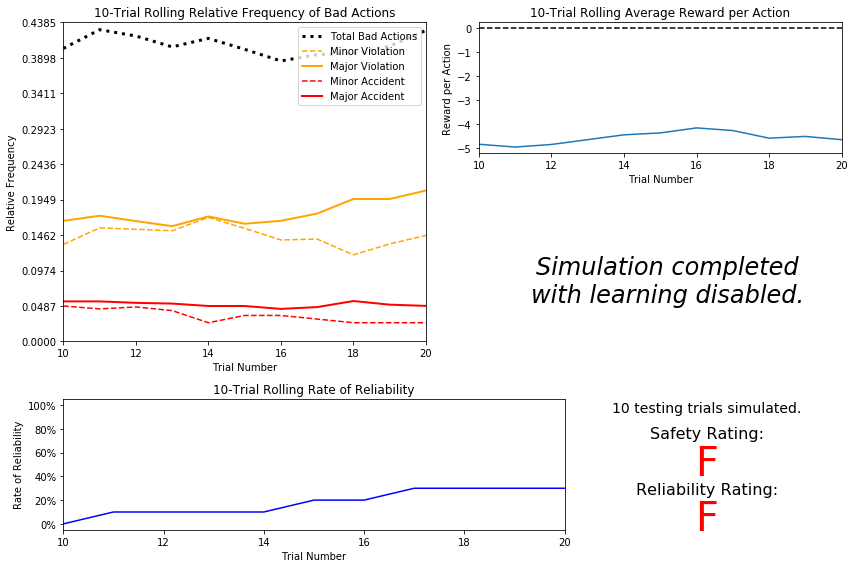

In [4]:
data = pd.read_csv('logs/sim_no-learning.csv')
print_additional_metrics(data)

# Load the 'sim_no-learning' log file from the initial simulation results
vs.plot_trials('sim_no-learning.csv')

### Question 3
Using the visualization above that was produced from your initial simulation, provide an analysis and make several observations about the driving agent. Be sure that you are making at least one observation about each panel present in the visualization. Some things you could consider:
- *How frequently is the driving agent making bad decisions? How many of those bad decisions cause accidents?*
- *Given that the agent is driving randomly, does the rate of reliability make sense?*
- *What kind of rewards is the agent receiving for its actions? Do the rewards suggest it has been penalized heavily?*
- *As the number of trials increases, does the outcome of results change significantly?*
- *Would this Smartcab be considered safe and/or reliable for its passengers? Why or why not?*

**Answer:**

Roughly 42% of the driving agent's actions are bad and ca. 21% of them lead to accidents. It can be seen at the top-left plot.

Rate of reliability does not make sense because no actual learning is performed. Plot named "10-Trial Rolling Rate of Reliability" gives incorrect feeling of its growth. All accidentally-successful trials lie within rolling window that is why it looks like that. It can be seen at the first bottom-left plot.

The driving agent almost always receives negative rewards because its actions are random and only ca. 58% of them are good. So I can conclude that the agent is penalized heavily. It can be seen at the top-right plot.

Agent's results do not change significantly. Results are quite uniform as can be seen on top-left plot, "Total Bad Actions" curve. Uniformity of results caused by uniform distribution of numbers generated by random function.

This Smartcab cannot be considered as safe or reliable because its Safety and Reliability Ratings are graded as "F". It can be seen at bottom-right plot.

-----
## Inform the Driving Agent
The second step to creating an optimized Q-learning driving agent is defining a set of states that the agent can occupy in the environment. Depending on the input, sensory data, and additional variables available to the driving agent, a set of states can be defined for the agent so that it can eventually *learn* what action it should take when occupying a state. The condition of `'if state then action'` for each state is called a **policy**, and is ultimately what the driving agent is expected to learn. Without defining states, the driving agent would never understand which action is most optimal -- or even what environmental variables and conditions it cares about!

### Identify States
Inspecting the `'build_state()'` agent function shows that the driving agent is given the following data from the environment:
- `'waypoint'`, which is the direction the *Smartcab* should drive leading to the destination, relative to the *Smartcab*'s heading.
- `'inputs'`, which is the sensor data from the *Smartcab*. It includes 
  - `'light'`, the color of the light.
  - `'left'`, the intended direction of travel for a vehicle to the *Smartcab*'s left. Returns `None` if no vehicle is present.
  - `'right'`, the intended direction of travel for a vehicle to the *Smartcab*'s right. Returns `None` if no vehicle is present.
  - `'oncoming'`, the intended direction of travel for a vehicle across the intersection from the *Smartcab*. Returns `None` if no vehicle is present.
- `'deadline'`, which is the number of actions remaining for the *Smartcab* to reach the destination before running out of time.

### Question 4
*Which features available to the agent are most relevant for learning both **safety** and **efficiency**? Why are these features appropriate for modeling the *Smartcab* in the environment? If you did not choose some features, why are those features* not *appropriate? Please note that whatever features you eventually choose for your agent's state, must be argued for here. That is: your code in agent.py should reflect the features chosen in this answer.
*

NOTE: You are not allowed to engineer new features for the smartcab. 

**Answer:**

Most of the data from `'inputs'` is relevant for safety. Knowing intentions of other drivers and seeing traffic lights is always crucial for safe driving. However intentions of driver on the right are not really relevant. If agent sees green light then only intentions of oncoming car matter. If agent sees red light only intentions of left car matter. So the right car cannot hinder agent's moves anyhow. `'waypoint'` is relevant for efficiency. Without a `waypoint` the agent would not know where to drive. `'deadline'` seems not that important. It could possibly help to choose a direction but in this case direction is already provided by waypoint so it cannot say more than 'hurry up'.

### Define a State Space
When defining a set of states that the agent can occupy, it is necessary to consider the *size* of the state space. That is to say, if you expect the driving agent to learn a **policy** for each state, you would need to have an optimal action for *every* state the agent can occupy. If the number of all possible states is very large, it might be the case that the driving agent never learns what to do in some states, which can lead to uninformed decisions. For example, consider a case where the following features are used to define the state of the *Smartcab*:

`('is_raining', 'is_foggy', 'is_red_light', 'turn_left', 'no_traffic', 'previous_turn_left', 'time_of_day')`.

How frequently would the agent occupy a state like `(False, True, True, True, False, False, '3AM')`? Without a near-infinite amount of time for training, it's doubtful the agent would ever learn the proper action!

### Question 5
*If a state is defined using the features you've selected from **Question 4**, what would be the size of the state space? Given what you know about the environment and how it is simulated, do you think the driving agent could learn a policy for each possible state within a reasonable number of training trials?*  
**Hint:** Consider the *combinations* of features to calculate the total number of states!

**Answer:**

The following features were selected in previous answer:

|Feature|Values|Number of values|
|-|-|-|
|light|green, red|2|
|waypoint|left, forward, right|3|
|inputs.left|left, forward, right, None|4|
|inputs.oncoming|left, forward, right, None|4|

State space size formed by these features defined by number of states each feature can be in:

$$size = 2 \cdot 3 \cdot 4 \cdot 4 = 96$$

This number is quite low if compare to number of states an agent can possibly be in during simulation. E.g. simulation of 1000 trials of 10 steps each would bring an agent through 10000 states. If we assume that distribution of states is uniform then it is 99% chance that all 96 states would be covered. So I conclude that the agent is able to learn a policy for each possible state within reasonable number of training trials.

### Update the Driving Agent State
For your second implementation, navigate to the `'build_state()'` agent function. With the justification you've provided in **Question 4**, you will now set the `'state'` variable to a tuple of all the features necessary for Q-Learning. Confirm your driving agent is updating its state by running the agent file and simulation briefly and note whether the state is displaying. If the visual simulation is used, confirm that the updated state corresponds with what is seen in the simulation.

**Note:** Remember to reset simulation flags to their default setting when making this observation!

-----
## Implement a Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to begin implementing the functionality of Q-Learning itself. The concept of Q-Learning is fairly straightforward: For every state the agent visits, create an entry in the Q-table for all state-action pairs available. Then, when the agent encounters a state and performs an action, update the Q-value associated with that state-action pair based on the reward received and the iterative update rule implemented. Of course, additional benefits come from Q-Learning, such that we can have the agent choose the *best* action for each state based on the Q-values of each state-action pair possible. For this project, you will be implementing a *decaying,* $\epsilon$*-greedy* Q-learning algorithm with *no* discount factor. Follow the implementation instructions under each **TODO** in the agent functions.

Note that the agent attribute `self.Q` is a dictionary: This is how the Q-table will be formed. Each state will be a key of the `self.Q` dictionary, and each value will then be another dictionary that holds the *action* and *Q-value*. Here is an example:

```
{ 'state-1': { 
    'action-1' : Qvalue-1,
    'action-2' : Qvalue-2,
     ...
   },
  'state-2': {
    'action-1' : Qvalue-1,
     ...
   },
   ...
}
```

Furthermore, note that you are expected to use a *decaying* $\epsilon$ *(exploration) factor*. Hence, as the number of trials increases, $\epsilon$ should decrease towards 0. This is because the agent is expected to learn from its behavior and begin acting on its learned behavior. Additionally, The agent will be tested on what it has learned after $\epsilon$ has passed a certain threshold (the default threshold is 0.05). For the initial Q-Learning implementation, you will be implementing a linear decaying function for $\epsilon$.

### Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'n_test'` - Set this to `'10'` to perform 10 testing trials.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.

In addition, use the following decay function for $\epsilon$:

$$ \epsilon_{t+1} = \epsilon_{t} - 0.05, \hspace{10px}\textrm{for trial number } t$$

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the initial Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

Average Reward -3.29919545783
Bad Actions Mean 0.249492282989
Bad Actions Median 0.222189336979
Average probability of major accident 0.0625166758889
Fraction of actions that led to accidents 0.305504516018


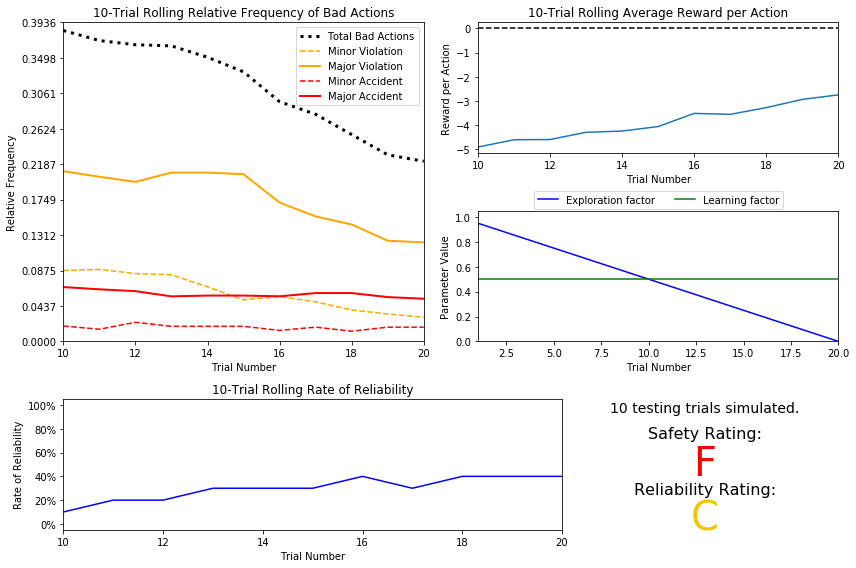

In [5]:
data = pd.read_csv('logs/sim_default-learning.csv')
print_additional_metrics(data)

# Load the 'sim_default-learning' file from the default Q-Learning simulation
vs.plot_trials('sim_default-learning.csv')

### Question 6
Using the visualization above that was produced from your default Q-Learning simulation, provide an analysis and make observations about the driving agent like in **Question 3**. Note that the simulation should have also produced the Q-table in a text file which can help you make observations about the agent's learning. Some additional things you could consider:  
- *Are there any observations that are similar between the basic driving agent and the default Q-Learning agent?*
- *Approximately how many training trials did the driving agent require before testing? Does that number make sense given the epsilon-tolerance?*
- *Is the decaying function you implemented for $\epsilon$ (the exploration factor) accurately represented in the parameters panel?*
- *As the number of training trials increased, did the number of bad actions decrease? Did the average reward increase?*
- *How does the safety and reliability rating compare to the initial driving agent?*

**Answer:**

Simulation results for default Q-Learning agent are quite different from results of default agent. But there are some similarities. Safety Ratings are still "F". Reliability Rating is better - "C" but from time to time it is also drops to "F". This is because there are still quite a lot of major accidents and unsuccessful trial results. Perhaps increasing number of testing trials would stabilize ratings.

Nevertheless results look better. Average Reward per Action increased (`mean=-3.299` vs `mean=-5.047`). Median probability of bad actions decreased (`median=0.222` vs `median=0.420`). Average probability of all violations and accidents except major accidents decreased.

||Major Accident|Minor Accident|Major Violation|Minor Violation|
|-|-|-|-|-|
|Default Agent|0.0555|0.0290|0.1976|0.1340|
|Q-Learning Default Agent|0.0619|0.0135|0.1222|0.0297|

Probabilities of all violations and accidents (even minor and major accidents, their slopes are -0.0003 and -0.001 respectively) have shown decreasing trends while same features of default agent did not:

|Default Agent|Q-Learning Default Agent|
|-|-|
|<img src="default.png"></img>|<img src="qlearning.png"></img>|

Driving agent performed 20 training trials before testing. This value makes sense but seems too low because number of bad actions seemingly is able to decrease further. Changing epsilon tolerance will not help much here but changing a decaying function for epsilon should improve results.

So results improved but there is a way ratings are still bad.

-----
## Improve the Q-Learning Driving Agent
The third step to creating an optimized Q-Learning agent is to perform the optimization! Now that the Q-Learning algorithm is implemented and the driving agent is successfully learning, it's necessary to tune settings and adjust learning paramaters so the driving agent learns both **safety** and **efficiency**. Typically this step will require a lot of trial and error, as some settings will invariably make the learning worse. One thing to keep in mind is the act of learning itself and the time that this takes: In theory, we could allow the agent to learn for an incredibly long amount of time; however, another goal of Q-Learning is to *transition from experimenting with unlearned behavior to acting on learned behavior*. For example, always allowing the agent to perform a random action during training (if $\epsilon = 1$ and never decays) will certainly make it *learn*, but never let it *act*. When improving on your Q-Learning implementation, consider the implications it creates and whether it is logistically sensible to make a particular adjustment.

### Improved Q-Learning Simulation Results
To obtain results from the initial Q-Learning implementation, you will need to adjust the following flags and setup:
- `'enforce_deadline'` - Set this to `True` to force the driving agent to capture whether it reaches the destination in time.
- `'update_delay'` - Set this to a small value (such as `0.01`) to reduce the time between steps in each trial.
- `'log_metrics'` - Set this to `True` to log the simluation results as a `.csv` file and the Q-table as a `.txt` file in `/logs/`.
- `'learning'` - Set this to `'True'` to tell the driving agent to use your Q-Learning implementation.
- `'optimized'` - Set this to `'True'` to tell the driving agent you are performing an optimized version of the Q-Learning implementation.

Additional flags that can be adjusted as part of optimizing the Q-Learning agent:
- `'n_test'` - Set this to some positive number (previously 10) to perform that many testing trials.
- `'alpha'` - Set this to a real number between 0 - 1 to adjust the learning rate of the Q-Learning algorithm.
- `'epsilon'` - Set this to a real number between 0 - 1 to adjust the starting exploration factor of the Q-Learning algorithm.
- `'tolerance'` - set this to some small value larger than 0 (default was 0.05) to set the epsilon threshold for testing.

Furthermore, use a decaying function of your choice for $\epsilon$ (the exploration factor). Note that whichever function you use, it **must decay to **`'tolerance'`** at a reasonable rate**. The Q-Learning agent will not begin testing until this occurs. Some example decaying functions (for $t$, the number of trials):

$$ \epsilon = a^t, \textrm{for } 0 < a < 1 \hspace{50px}\epsilon = \frac{1}{t^2}\hspace{50px}\epsilon = e^{-at}, \textrm{for } 0 < a < 1 \hspace{50px} \epsilon = \cos(at), \textrm{for } 0 < a < 1$$
You may also use a decaying function for $\alpha$ (the learning rate) if you so choose, however this is typically less common. If you do so, be sure that it adheres to the inequality $0 \leq \alpha \leq 1$.

If you have difficulty getting your implementation to work, try setting the `'verbose'` flag to `True` to help debug. Flags that have been set here should be returned to their default setting when debugging. It is important that you understand what each flag does and how it affects the simulation! 

Once you have successfully completed the improved Q-Learning simulation, run the code cell below to visualize the results. Note that log files are overwritten when identical simulations are run, so be careful with what log file is being loaded!

Average Reward -0.723318706836
Bad Actions Mean 0.155098435364
Bad Actions Median 0.121124472749
Average probability of major accident 0.0227324238481
Fraction of actions that led to accidents 0.236594038556


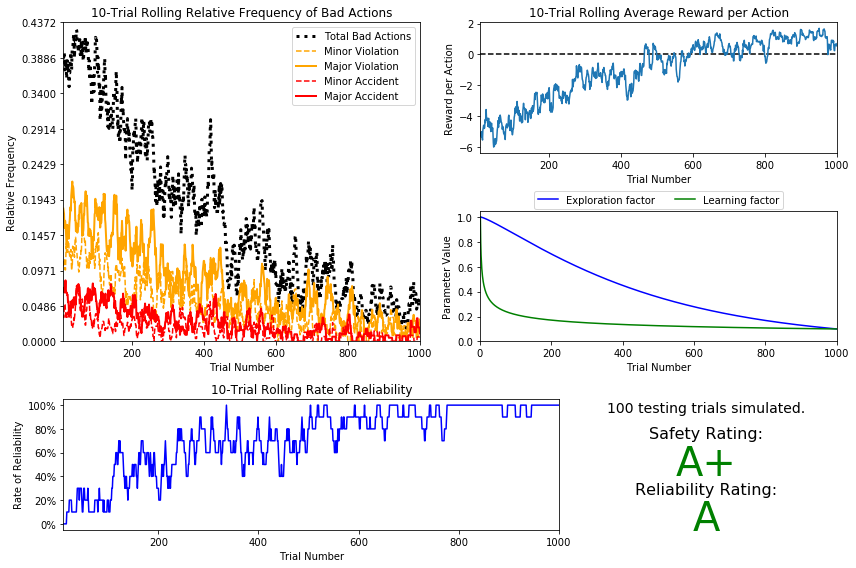

In [6]:
data = pd.read_csv('logs/sim_improved-learning.csv')
print_additional_metrics(data)

# Load the 'sim_improved-learning' file from the improved Q-Learning simulation
vs.plot_trials('sim_improved-learning.csv')

### Question 7
Using the visualization above that was produced from your improved Q-Learning simulation, provide a final analysis and make observations about the improved driving agent like in **Question 6**. Questions you should answer:  
- *What decaying function was used for epsilon (the exploration factor)?*
- *Approximately how many training trials were needed for your agent before begining testing?*
- *What epsilon-tolerance and alpha (learning rate) did you use? Why did you use them?*
- *How much improvement was made with this Q-Learner when compared to the default Q-Learner from the previous section?*
- *Would you say that the Q-Learner results show that your driving agent successfully learned an appropriate policy?*
- *Are you satisfied with the safety and reliability ratings of the *Smartcab*?*

**Answer:**

In order to handle exploration/exploitation trade-off the exploration factor (epsilon, $\epsilon$) should decay. To achieve that the following decaying function is utilized:

$$\epsilon_{t+1} = \alpha_t^\frac{t}{1000}$$

The other decaying function is applied to learning rate (alpha, $\alpha$):

$$\alpha_{t+1} = \Bigl(\frac{1}{t}\Bigr)^{1/3}$$

So epsilon reaches tolerance value after ca. 1000 trials. This is enough for getting good results on testing stage. Tolerance is set to 0.1 because lower tolerance is redundant - decreasing epsilon further does not improve results. Decaying function for alpha helps to speedup convergence and makes a decrease of epsilon almost linear but without a chance to get below zero.

Results of optimized agent and default agent differ dramatically. Average reward became more that four times higher (-0.7233 vs -3.2991). Average probability of major accident is almost four times lower for Optimized Agent. Average probability of major violation for Optimized Agent is almost twice lower. Average probabilities of minor accident and minor violation are about the same. It is summarized in the table below:

||Major Accident|Minor Accident|Major Violation|Minor Violation|
|-|-|-|-|-|
|Q-Learning Default Agent|0.0619|0.0135|0.1222|0.0297|
|Optimized Q-Learning Agent|0.0227|0.0139|0.0723|0.0460|

Probabilities of all violations and accidents have shown even more secure decreasing trends than for Q-Learning Default Agent:

|Default Agent|Q-Learning Default Agent|
|-|-|
|<img src="qlearning.png"></img>|<img src="optimized.png"></img>|

Looking at results obtained I would say that the driver agent successfully learned an appropriate policy. After numerous reruns of simulation it repeatedly shows good result on testing stage - A or A+ Safety Score and A or A+ Reliability Score. That is why I am completely satisfied with scores of the Smartcab.

### Define an Optimal Policy

Sometimes, the answer to the important question *"what am I trying to get my agent to learn?"* only has a theoretical answer and cannot be concretely described. Here, however, you can concretely define what it is the agent is trying to learn, and that is the U.S. right-of-way traffic laws. Since these laws are known information, you can further define, for each state the *Smartcab* is occupying, the optimal action for the driving agent based on these laws. In that case, we call the set of optimal state-action pairs an **optimal policy**. Hence, unlike some theoretical answers, it is clear whether the agent is acting "incorrectly" not only by the reward (penalty) it receives, but also by pure observation. If the agent drives through a red light, we both see it receive a negative reward but also know that it is not the correct behavior. This can be used to your advantage for verifying whether the **policy** your driving agent has learned is the correct one, or if it is a **suboptimal policy**.

### Question 8

1. Please summarize what the optimal policy is for the smartcab in the given environment. What would be the best set of instructions possible given what we know about the environment? 
   _You can explain with words or a table, but you should thoroughly discuss the optimal policy._

2. Next, investigate the `'sim_improved-learning.txt'` text file to see the results of your improved Q-Learning algorithm. _For each state that has been recorded from the simulation, is the **policy** (the action with the highest value) correct for the given state? Are there any states where the policy is different than what would be expected from an optimal policy?_ 

3. Provide a few examples from your recorded Q-table which demonstrate that your smartcab learned the optimal policy. Explain why these entries demonstrate the optimal policy.

4. Try to find at least one entry where the smartcab did _not_ learn the optimal policy.  Discuss why your cab may have not learned the correct policy for the given state.

Be sure to document your `state` dictionary below, it should be easy for the reader to understand what each state represents.

**Answer:** 

**0. Reading tables of states**

Q-table dictionary contains states and possible actions to take. Keys are states values are actions. To answer this question Q-table is transformed to table. Headers are explained below:

- index - number of state for reference
- light - traffic light seen by agent
- forward - reward for going forward
- left - reward for going left
- right - reward for going right
- none - reward for no action
- waypoint - intended direction of the agent
- intention of left - intended direction of car on the left
- intention of oncoming - intended direction of oncoming car
- max - direction eventually chosen by the agent for this state

Example:

|index|light|forward|left|right|none|waypoint|intention of left|intention of oncoming|max|
|-|-|-|-|-|-|-|-|-|-|-|
|9|green|0.20|-12.73|1.00|-2.47|forward|left|right|right|

State 9 (index), light is green (light), oncoming car intends to go right (intention of oncoming), cars on the left and right can be ignored because they should yield the right of way to the agent (light); agent's intended direction is forward (waypoint) but maximal reward is given for going right (right) so agent goes right (max).

**1. Optimal Policy**

Optimal policy for the environment is the U.S. right-of-way traffic laws. It applied to the environment and summarized with the following statements:

1. moving forward and left is prohibited if light is red
1. moving right is allowed if light is red but right-of-way should be yielded to those who move down perpendicular road in agent's intended direction
1. moving forward and right is allowed if light is green
1. moving left is allowed if light is green and if there is no oncoming car or oncoming car does not go forward or right

**2. Q-table**

Most of the states have policy that is as expected (96.9%). But there are some states where policy is correct but unexpected. So it is correct in terms of safety and right-of-way laws but for some reason max Q-value does not agree with waypoint. For example the agent could go forward instead of going right (in waypoint direction) just because a reward for going forward is larger.

**3. Examples of Optimal Policy**

Each rule Optimal Policy from Point 1 can be exemplified by some states or their absence.

Rule 1

There is no states that violate this rule.

Rule 2

States below confirm the second rule.

If light is red and there is no car to the left that intends to go forward then agent is free to move right if it needs to (see state 54). If light is red and there is a car to the left that intends to go forward then agent does not take any action (see state 52).

|index|light|forward|left|right|none|waypoint|intention of left|intention of oncoming|max|
|-|-|-|-|-|-|-|-|-|-|-|
|52|red|-21.72|-20.33|-4.13|0.81|right|forward|right|none|
|54|red|-12.92|-14.86|1.91|0.96|right|none|none|right|

Rule 3

State below confirms the third rule. If light is green and there is no cars that should be yielded then agent is free to move in intended direction.

|index|light|forward|left|right|none|waypoint|intention of left|intention of oncoming|max|
|-|-|-|-|-|-|-|-|-|-|-|
|11|green|2.11|0.63|0.61|-5.13|forward|right|none|forward|

Rule 4

State below confirms the fourth rule.
If oncoming car intends to go right and agent intends to go left then agent yields the right of way to that car and goes forward to avoid accident.

|index|light|forward|left|right|none|waypoint|intention of left|intention of oncoming|max|
|-|-|-|-|-|-|-|-|-|-|-|
|78|green|0.95|-16.89|0.71|-2.76|left|forward|right|forward|

**Sub-optimal policies**

There are some examples of sub-optimal policies learned by agent. In 3.1% of states direction of maximal Q-value does not agree with waypoint due to reasons not related to Optimal Policy.

Let look at example below:

|index|light|forward|left|right|none|waypoint|intention of left|intention of oncoming|max|
|-|-|-|-|-|-|-|-|-|-|-|
|85|green|0.00|-2.44|0.58|-0.67|forward|right|right|right|

The agent intends to go forward (waypoint) but the reward for going right is larger and that is why it goes right. However there is no obstacles that could prevent it from going in intended direction. The reason of this distribution of rewards can lie at the number of trials. During learning the agent possibly becomes biased towards immediate rewards, so incorrect rewards gained before as a result of random action would become the largest ones that cannot be beaten by optimal actions anymore.

-----
### Optional: Future Rewards - Discount Factor, `'gamma'`
Curiously, as part of the Q-Learning algorithm, you were asked to **not** use the discount factor, `'gamma'` in the implementation. Including future rewards in the algorithm is used to aid in propagating positive rewards backwards from a future state to the current state. Essentially, if the driving agent is given the option to make several actions to arrive at different states, including future rewards will bias the agent towards states that could provide even more rewards. An example of this would be the driving agent moving towards a goal: With all actions and rewards equal, moving towards the goal would theoretically yield better rewards if there is an additional reward for reaching the goal. However, even though in this project, the driving agent is trying to reach a destination in the allotted time, including future rewards will not benefit the agent. In fact, if the agent were given many trials to learn, it could negatively affect Q-values!

### Optional Question 9
*There are two characteristics about the project that invalidate the use of future rewards in the Q-Learning algorithm. One characteristic has to do with the *Smartcab* itself, and the other has to do with the environment. Can you figure out what they are and why future rewards won't work for this project?*

**Answer:**

**Agent**: the Smartcab is not aware how far is a state from the destination because states are independent from a position. So any state is relevant at any place of the world. That is why it is impossible to get higher reward if the agent is closer to destination.

**Environment**: the destination is moved every trial so even if states were linkable to positions (coordinates) then previous experience of the agent would become irrelevant after every trial because switching to highly rewarded state would not make the agent closer to the destination anymore.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.